# Yearbook of International Organizations Analysis

This notebook analyzes the dataset scraped from the Yearbook of International Organizations (YBIO).

**Dataset:** `data/organizations_final.csv`

**Author:** Diwas Puri (diwas.puri@duke.edu), Duke University


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Load data
try:
    df = pd.read_csv('../data/organizations_clean.csv')
    print("Successfully loaded data from ../data/organizations_clean.csv")
except FileNotFoundError:
    # Fallback for running from root
    try:
        df = pd.read_csv('data/organizations_clean.csv')
        print("Successfully loaded data from data/organizations_clean.csv")
    except FileNotFoundError:
        print("Error: Could not find dataset!")

# Display basic info
if 'df' in locals():
    print(f"Total Organizations: {len(df):,}")
    print(f"Columns: {list(df.columns)}")
    display(df.head())

Successfully loaded data from ../data/organizations_clean.csv
Total Organizations: 78,865
Columns: ['Name', 'Acronym', 'Founded', 'City', 'Country', 'Type I', 'Type II', 'UID']


,Name,Acronym,Founded,City,Country,Type I,Type II,UID
0,Federation of International Dance Festivals,FIDAF,2012.0,Chungnam,Korea Rep,B,NaN,XJ9650
1,Federation of International Geo-Engineering So...,FedIGS,2007.0,NaN,NaN,B,y,AA0037
2,FIDI Global Alliance,NaN,1950.0,Zaventem,Belgium,B,NaN,XB0947
3,Food and Agriculture Organization of the Unite...,FAO,1945.0,Rome,Italy,B,g,XB0971
4,Gender and Water Alliance,GWA,2000.0,Dieren,Netherlands,B,NaN,XM0973


## 1. Data Cleaning & Preprocessing

In [2]:
# Missing counts and percentages
missing_counts = df.isnull().sum()
missing_pct = (missing_counts / len(df)) * 100
missing_summary = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_pct': missing_pct.round(2)
}).sort_values('missing_pct', ascending=False)

print("Missing Values per Column")
print(missing_summary)

# Top 10 columns with most missing values
print("\nTop 10 columns by missing percent")
print(missing_summary.head(10))


Missing Values per Column
         missing_count  missing_pct
City             31526        39.97
Country          31520        39.97
Acronym          29848        37.85
Type II          26978        34.21
Founded          23718        30.07
Name                 0         0.00
Type I               0         0.00
UID                  0         0.00

Top 10 columns by missing percent
         missing_count  missing_pct
City             31526        39.97
Country          31520        39.97
Acronym          29848        37.85
Type II          26978        34.21
Founded          23718        30.07
Name                 0         0.00
Type I               0         0.00
UID                  0         0.00


## 2. Geographic Analysis
Where are these organizations headquartered?

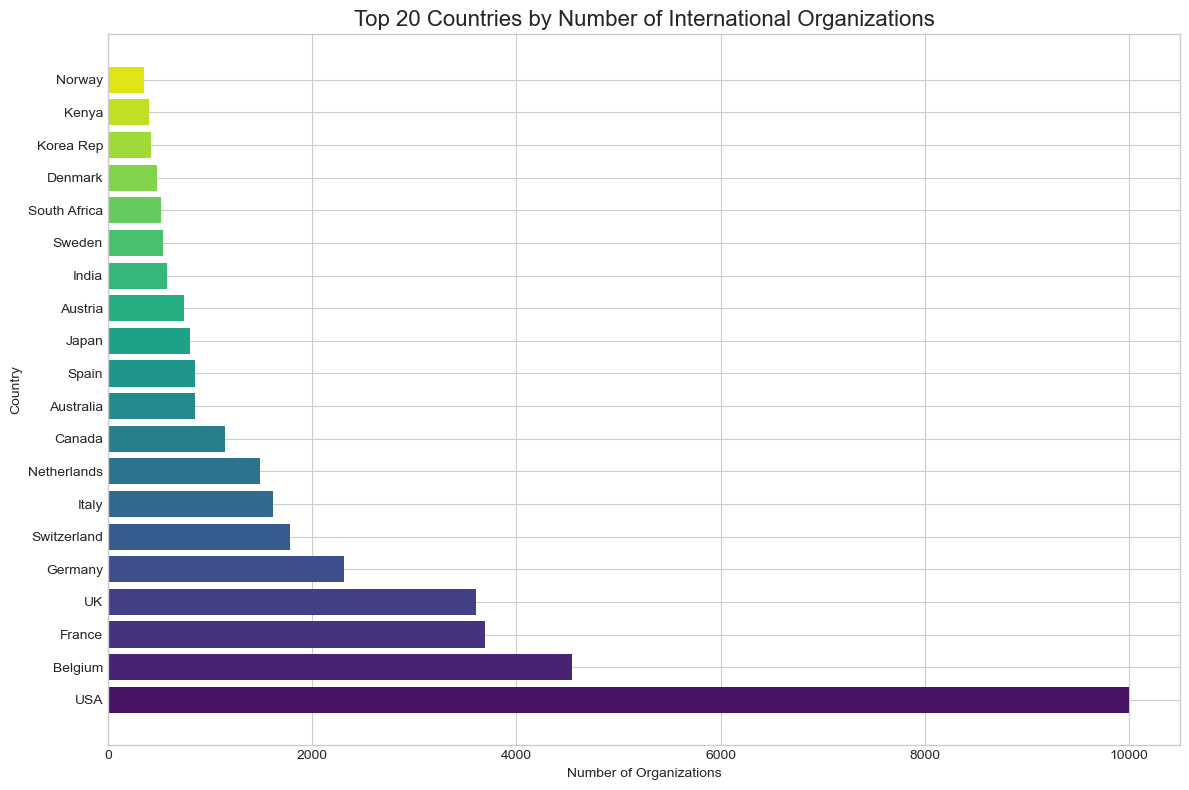

In [3]:
top_countries = df['Country'].value_counts().head(20)

colors = sns.color_palette('viridis', n_colors=len(top_countries))

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(top_countries.index, top_countries.values, color=colors)
ax.set_title('Top 20 Countries by Number of International Organizations', fontsize=16)
ax.set_xlabel('Number of Organizations')
ax.set_ylabel('Country')
plt.tight_layout()
plt.show()

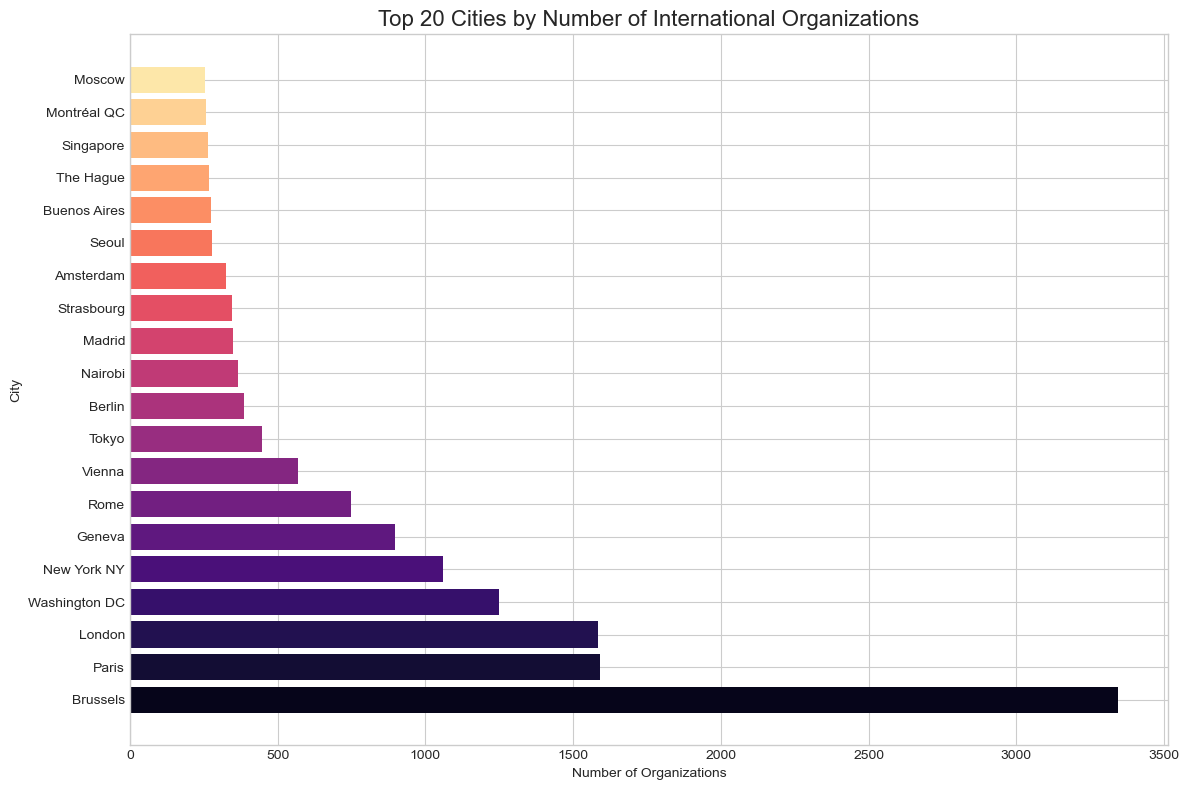

In [4]:
top_cities = df['City'].value_counts().head(20)
colors = sns.color_palette('magma', n_colors=len(top_cities))

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(top_cities.index, top_cities.values, color=colors)
ax.set_title('Top 20 Cities by Number of International Organizations', fontsize=16)
ax.set_xlabel('Number of Organizations')
ax.set_ylabel('City')
plt.tight_layout()
plt.show()


## 3. Temporal Analysis
When were these organizations established?

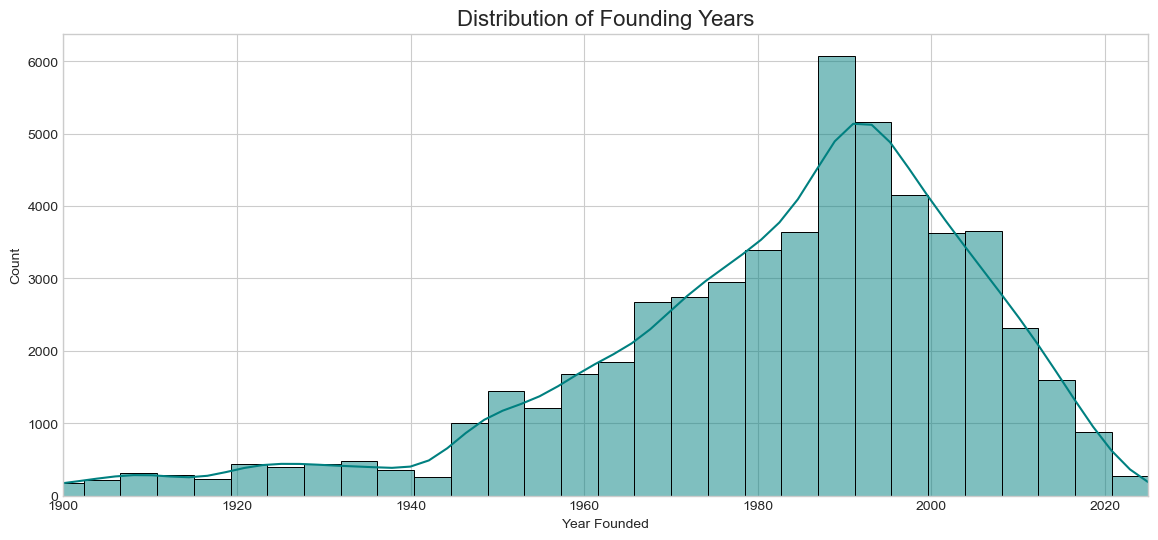

In [5]:

# Ensure valid_years_df exists
if 'valid_years_df' not in locals():
    if 'Founded_Year' not in df.columns:
        df['Founded_Year'] = pd.to_numeric(df['Founded'], errors='coerce')
    valid_years_df = df[(df['Founded_Year'] > 1600) & (df['Founded_Year'] <= 2025)]

plt.figure(figsize=(14, 6))
sns.histplot(data=valid_years_df, x='Founded_Year', bins=100, kde=True, color='teal')
plt.title('Distribution of Founding Years', fontsize=16)
plt.xlabel('Year Founded')
plt.ylabel('Count')
plt.xlim(1900, 2025)
plt.show()

### Understanding YBIO Classification

The Yearbook of International Organizations uses a two-tier classification system:

**Type I (Primary Category)**
- **A**: Federations of international organizations
- **B**: Universal membership organizations
- **C**: Intercontinental membership organizations
- **D**: Regionally defined membership organizations
- **E**: Organizations emanating from places, persons, or other bodies
- **F**: Organizations having a special form
- **G**: Recently reported or proposed organizations
- **H**: Dissolved or apparently inactive organizations
- **U**: Unconfirmed organizations

**Type II (Secondary Category)**
- **c**: International conferences
- **d**: Dissolved organizations
- **e**: National organizations
- **f**: Foundations
- **g**: Intergovernmental organizations
- **j**: Autonomous conference series
- **x**: Commercial or for-profit organizations
- **y**: International non-profit organizations

These classifications help researchers understand the scope, structure, and status of each organization.

## 4. Organization Types
Analyzing Type I and Type II classifications.

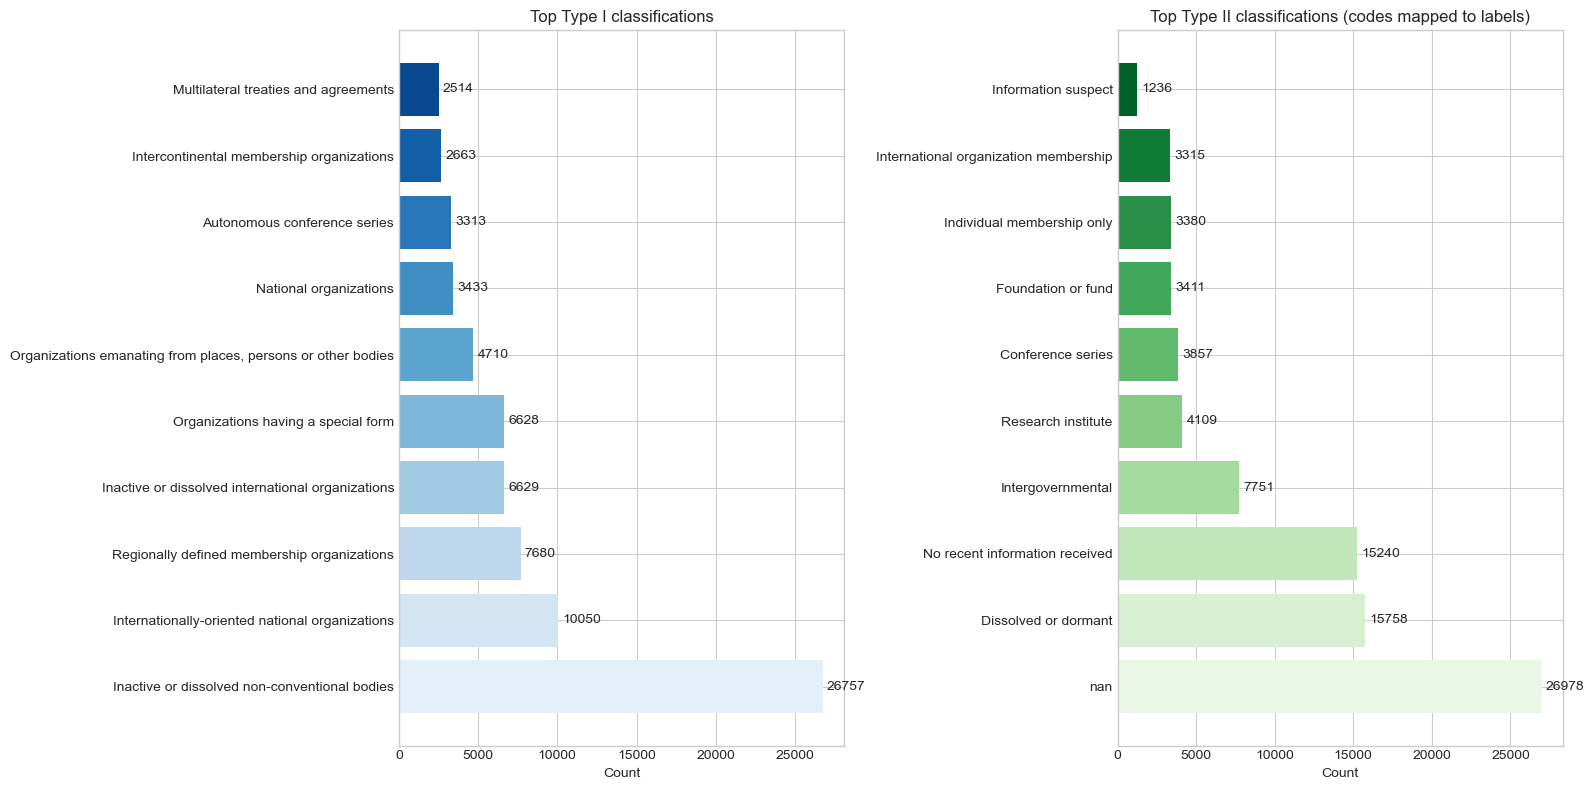

In [6]:


# --- Mappings ---
TYPE_I = {
    "A": "Federations of international organizations",
    "B": "Universal membership organizations",
    "C": "Intercontinental membership organizations",
    "D": "Regionally defined membership organizations",
    "E": "Organizations emanating from places, persons or other bodies",
    "F": "Organizations having a special form",
    "G": "Internationally-oriented national organizations",
    "H": "Inactive or dissolved international organizations",
    "J": "Recently reported or proposed international organizations",
    "K": "Subsidiary and internal bodies",
    "N": "National organizations",
    "R": "Religious orders, fraternities and secular institutes",
    "S": "Autonomous conference series",
    "T": "Multilateral treaties and agreements",
    "U": "Inactive or dissolved non-conventional bodies"
}

TYPE_II = {
    "b": "Bilateral intergovernmental organization",
    "c": "Conference series",
    "d": "Dissolved or dormant",
    "e": "Commercial enterprise",
    "f": "Foundation or fund",
    "g": "Intergovernmental",
    "j": "Research institute",
    "n": "Has become national",
    "p": "Proposed body",
    "s": "Information suspect",
    "v": "Individual membership only",
    "x": "No recent information received",
    "y": "International organization membership"
}

# --- Helper to parse Type II robustly ---
def split_type2_codes(val):
    if pd.isna(val):
        return []
    s = str(val).strip()
    for sep in [",", ";", "/", "|"]:
        s = s.replace(sep, " ")
    parts = [p.strip() for p in s.split() if p.strip()]
    codes = []
    for p in parts:
        if len(p) > 1 and all(ch in TYPE_II for ch in p):
            codes.extend(list(p))
        else:
            codes.append(p)
    return codes

# --- Map and prepare counts (assumes `df` exists) ---
df_plot = df.copy()
df_plot["Type I Label"] = df_plot["Type I"].astype(str).str.strip().map(TYPE_I).fillna("Unknown Type I")
df_plot["Type II Codes"] = df_plot["Type II"].apply(split_type2_codes)

# Count Type I
type1_counts = df_plot["Type I Label"].value_counts().head(10)

# Flatten Type II codes and map to labels, then count
type2_exploded = df_plot.explode("Type II Codes")
type2_exploded["Type II Label"] = type2_exploded["Type II Codes"].map(TYPE_II).fillna(type2_exploded["Type II Codes"].astype(str))
type2_counts = type2_exploded["Type II Label"].value_counts().head(10)

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Type I (horizontal bar)
colors1 = sns.color_palette("Blues_r", n_colors=len(type1_counts))
axes[0].barh(type1_counts.index[::-1], type1_counts.values[::-1], color=colors1)
axes[0].set_title("Top Type I classifications")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("")
axes[0].invert_yaxis()

# Annotate Type I bars
for i, v in enumerate(type1_counts.values[::-1]):
    axes[0].text(v + max(type1_counts.values) * 0.01, i, str(v), va="center")

# Type II (horizontal bar)
colors2 = sns.color_palette("Greens_r", n_colors=len(type2_counts))
axes[1].barh(type2_counts.index[::-1], type2_counts.values[::-1], color=colors2)
axes[1].set_title("Top Type II classifications (codes mapped to labels)")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("")
axes[1].invert_yaxis()

# Annotate Type II bars
for i, v in enumerate(type2_counts.values[::-1]):
    axes[1].text(v + max(type2_counts.values) * 0.01, i, str(v), va="center")

plt.tight_layout()
plt.show()


## 5. Word Cloud of Names

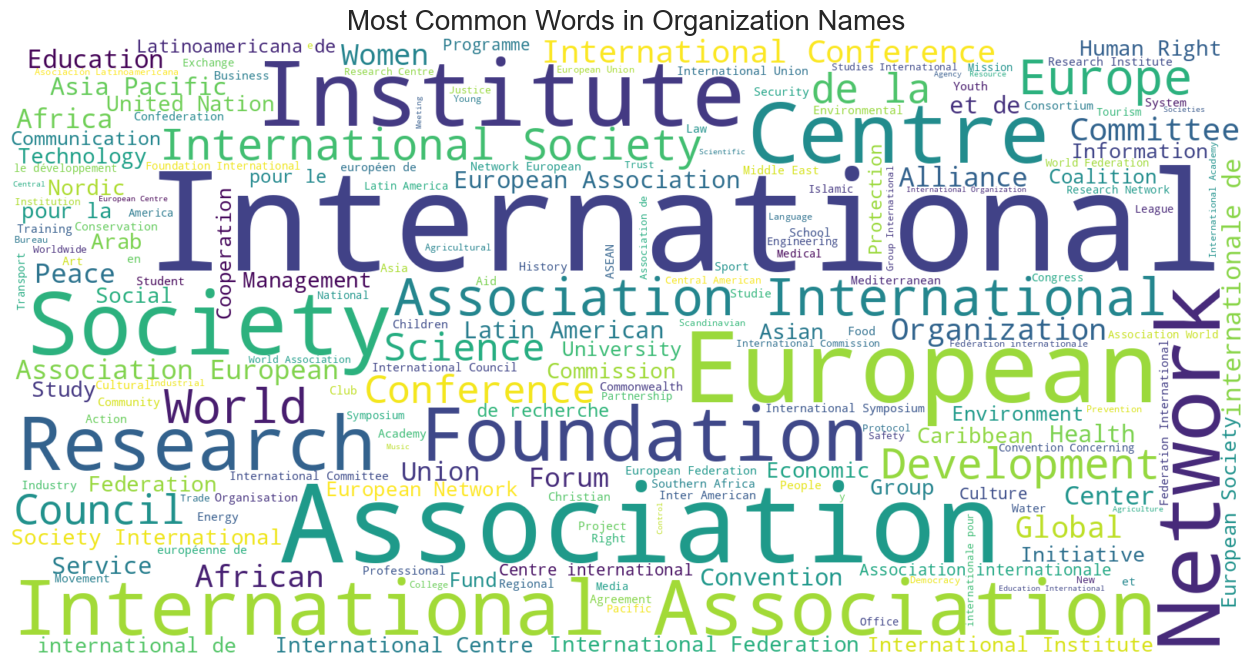

In [7]:
from wordcloud import WordCloud

# Combine all names
text = ' '.join(df['Name'].dropna().astype(str))

# Generate word cloud
wordcloud = WordCloud(width=1600, height=800, background_color='white', colormap='viridis').generate(text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Organization Names', fontsize=20)
plt.show()

## 6. Geographic Distribution - Interactive World Map

Visualizing the global distribution of international organizations.

In [ ]:
# Aggregate organizations by country
country_stats = df_mapped.groupby('Country').agg({
    'latitude': 'first',
    'longitude': 'first',
    'Name': 'count'
}).rename(columns={'Name': 'count'}).reset_index()

print(f"Countries with organizations: {len(country_stats)}")
print(f"Total mapped organizations: {country_stats['count'].sum()}")
print(f"\nTop 10 countries by organization count:")
print(country_stats.nlargest(10, 'count')[['Country', 'count']].to_string(index=False))

In [ ]:
# Create interactive map with country-level aggregation
m = folium.Map(location=[20, 0], zoom_start=2, tiles='OpenStreetMap', control_scale=True)

# Add circle markers sized by number of organizations
for idx, row in country_stats.iterrows():
    # Get sample organizations from this country
    country_orgs = df_mapped[df_mapped['Country'] == row['Country']]['Name'].head(10).tolist()
    sample_list = '<br>• '.join(country_orgs[:5])
    more_text = f"<br>...and {row['count']-5} more" if row['count'] > 5 else ""
    
    popup_html = f"""
    <div style="width: 350px;">
        <h3>{row['Country']}</h3>
        <b>Total Organizations:</b> {row['count']}<br><br>
        <b>Sample Organizations:</b><br>
        • {sample_list}{more_text}
    </div>
    """
    
    # Circle size based on number of orgs (logarithmic scale)
    radius = max(5, min(30, 5 + np.log10(row['count'] + 1) * 8))
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=radius,
        popup=folium.Popup(popup_html, max_width=350),
        tooltip=f"{row['Country']}: {row['count']} organizations",
        color='darkblue',
        fill=True,
        fillColor='steelblue',
        fillOpacity=0.6,
        weight=2
    ).add_to(m)

m.save('../data/organizations_map.html')
print("✓ Interactive map saved to: data/organizations_map.html")
m

In [ ]:
# Create heatmap of organization density
m_heat = folium.Map(location=[20, 0], zoom_start=2, tiles='OpenStreetMap')

# Prepare heat data with weights (one entry per country with weight = org count)
heat_data = [[row['latitude'], row['longitude'], row['count']] 
             for idx, row in country_stats.iterrows()]

HeatMap(
    heat_data,
    name='Organization Density',
    min_opacity=0.3,
    max_zoom=13,
    radius=25,
    blur=30,
    gradient={0.4: 'blue', 0.6: 'lime', 0.8: 'yellow', 1.0: 'red'}
).add_to(m_heat)

m_heat.save('../data/organizations_heatmap.html')
print("✓ Heatmap saved to: data/organizations_heatmap.html")
m_heat